In [241]:
import os
import pandas as pd 
import numpy as np 
import time

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import History
from keras.layers.advanced_activations import PReLU, LeakyReLU
from sklearn.preprocessing import MinMaxScaler

In [279]:
import pandas as pd
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, \
    r2_score
import math
import matplotlib.pyplot as plt

In [544]:
# 输入数据
INPUT_DATA = "blackmetal/data/shuju1.csv"
# 需要加入训练的特征长度
# FEATURE_LEN = 5
# 时间序列长度
SEQ_LEN = 20
# 预测步长
STEP_LEN = 20
# epochs大小
EPOCHS = 500
# 批大小
BATCH_SIZE = 128
# 测试训练集比例
TRAIN_SAMPLES_RATE = 0.8
# 网络形状
LAYERS = [41, SEQ_LEN, 100, STEP_LEN]

In [545]:
def min_max_normal(train,test):
    # 对数据进行归一化
    scaler = MinMaxScaler()
    scalerModel = scaler.fit(train)
    _train = scalerModel.transform(train)
    _test  = scalerModel.transform(test)
    return _train, _test, scalerModel

def reshape_data(data, SEQ_LEN):
    reshape_data = []
    for i in range(len(data) - SEQ_LEN):
        reshape_data.append(data[i: i + SEQ_LEN])
    return np.array(reshape_data)

In [546]:
def build_model():
    """
    定义模型
    """
    model = Sequential()

    model.add(LSTM(units=LAYERS[1], input_shape=(LAYERS[1], LAYERS[0]), return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(LAYERS[2], return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=LAYERS[3]))
    model.add(BatchNormalization(weights=None, epsilon=1e-06, momentum=0.9))
    model.add(Activation("tanh"))
    # act = PReLU(alpha_initializer='zeros', weights=None)
    # act = LeakyReLU(alpha=0.3)
    # model.add(act)

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

In [547]:
raw_data = pd.read_csv(INPUT_DATA)

In [548]:
raw_data.columns = ["date", "time", "open", "close", "high", "low", "volume", 
                     "p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8", "p9", "p10",
                     "p11", "p12", "p13", "p14", "p15", "p16", "p17", "p18", "p19", "p20", 
                     "p21", "p22", "p23", "p24", "p25", "p26", "p27", "p28", "p29", "p30",
                     "p31", "p32", "p33", "p34", "p35", "p36", "p37"]

In [551]:

train_samples_num = int((len(raw_data) - STEP_LEN) * TRAIN_SAMPLES_RATE)

# Divide features and labels
labels = raw_data[["date", "time","high"]]
labels_tag = labels["high"]
data =  raw_data.drop(['high'],axis=1) # 删除需要预测的数据行
features = data.drop(["date", "time"],axis=1)

In [552]:
_x_train = np.array(features[:train_samples_num])
_x_test = np.array(features[train_samples_num:-STEP_LEN])
_y_train = np.array(labels_tag).T[STEP_LEN:(train_samples_num + STEP_LEN)]
_y_test = np.array(labels_tag).T[train_samples_num + STEP_LEN:]
#_y_train = _y_train[:, np.newaxis] # 行向量转化为列向量
#_y_test = _y_test[:, np.newaxis]
print _x_train.shape, _x_test.shape, _y_train.shape, _y_test.shape,
print train_samples_num

(16152, 41) (4039, 41) (16152,) (4039,) 16152


In [553]:
    _x_train, _x_test, x_scaler = min_max_normal(_x_train, _x_test)
    _y_train, _y_test, y_scaler = min_max_normal(_y_train, _y_test)
    
    x_train = reshape_data(_x_train, SEQ_LEN)
    x_test = reshape_data(_x_test, SEQ_LEN)
    y_train = reshape_data(_y_train, STEP_LEN)
    y_test = reshape_data(_y_test, STEP_LEN)

    #print len(features), len(_x_train), len(_x_test), len(y_train), len(y_test)
    print x_train.shape, y_train.shape, x_test.shape, y_test.shape

  #  return [x_train, x_test, y_train, y_test, labels, labels_tag, data, features, x_scaler, y_scaler]

/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

(16132, 20, 41) (16132, 20) (4019, 20, 41) (4019, 20)


In [554]:
print labels.shape, labels_tag.shape, features.shape

(20211, 3) (20211,) (20211, 41)


In [555]:
def model_evaluation(y_true, y_pred):
    metrics = _cal_metrics(y_true, y_pred)
    for (k, v) in metrics.items():
        print(k + ": " + str(v))


def model_evaluation_multi_step(y_true, y_pred):
    print(y_true.shape, y_pred.shape)
    # y_true.shape = (1010, 20)
    metrics_list = []
    # 分别求t + 1, t + 2, ... , t + STEP_LEN 每天的评估指标
    for i in range(len(y_true.T)):
        metrics = _cal_metrics(pd.DataFrame(y_true.T[i]), pd.DataFrame(y_pred.T[i]))
        metrics_list.append(metrics)
        print("-------------------------------------------------------------------------")
        print("metrics of t + " + str(i + 1))
        print("-------------------------------------------------------------------------")
        for (k, v) in metrics.items():
            print("\r" + k + ": " + str(v))

    # 求总体平均
    for i in range(1, len(metrics_list)):
        for (k, v) in metrics_list[0].items():
            metrics_list[0][k] += metrics_list[i][k]
    print("-------------------------------------------------------------------------")
    print("metrics of avg")
    print("-------------------------------------------------------------------------")
    for (k, v) in metrics_list[0].items():
        print("\r" + k + ": " + str(float(v) / y_true.shape[1]))


def _cal_metrics(y_true, y_pred):
    """
    计算各个指标的值
    """
    re = _calc_re(y_true, y_pred)
    metrics = {
        "explained_variance_score":
            explained_variance_score(y_true, y_pred),
        "mean_absolute_error":
            mean_absolute_error(y_true, y_pred),
        "mean_squared_error":
            mean_squared_error(y_true, y_pred),
        "median_absolute_error":
            median_absolute_error(y_true, y_pred),
        "r2_score":
            r2_score(y_true, y_pred),
        "sum_relative_error":
            re[0],
        "mean_relative_error":
            re[1]
    }

    return metrics


def _calc_re(y_true, y_pred):
    """
    计算相对误差（Sum/Mean Relative Error）
    """
    return [((y_true - y_pred) / y_pred).sum().values, ((y_true - y_pred) / y_pred).mean().values]


def _calc_trend_accuracy(predict, fed_data):
    """
    趋势正确性评估，即判断当前收盘价与前一天收盘价对比上升/下降趋势是否正确
    """
    # 全局索引
    global_index = fed_data.index
    # 预测的样本总数
    predict_sample_no = predict.size
    # 预测结果趋势正确的样本总数
    correct_trend_no = 0
    for index, pre in predict.iterrows():
        # 获取前一天记录的索引值
        pre_index = global_index.get_values()[global_index.get_loc(index) - 1]
        # 获取前一天的收盘价
        v_pre = fed_data.loc[pre_index]['close_price_i']
        # 获取当前的收盘价
        v_target = fed_data.loc[index]['close_price_i']
        # 当天收盘价的预测值
        v_predict = pre[0]
        if (v_target - v_pre) * (v_predict - v_pre) > 0:
            correct_trend_no += 1
    print("trend accuracy rate: " + str(correct_trend_no / predict_sample_no))


In [556]:
def load_data():
    raw_data = pd.read_csv(INPUT_DATA)
    #print(len(raw_data))
    raw_data.columns = ["date", "time", "open", "close", "high", "low", "volume",
                     "p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8", "p9", "p10",
                     "p11", "p12", "p13", "p14", "p15", "p16", "p17", "p18", "p19", "p20",
                     "p21", "p22", "p23", "p24", "p25", "p26", "p27", "p28", "p29", "p30",
                     "p31", "p32", "p33", "p34", "p35", "p36", "p37"]

    #raw_data = raw_data[['price_date'] + Conf.FIELDS].dropna()
    #print(len(raw_data))
    train_samples_num = int((len(raw_data) - STEP_LEN) * TRAIN_SAMPLES_RATE)
    
    # Divide features and labels
    labels = raw_data[["date", "time","high"]]
    labels_tag = labels["high"]
    data =  raw_data.drop(['high'],axis=1) # 删除需要预测的数据行
    features = data.drop(["date", "time"],axis=1)
    
    _x_train = np.array(features[:train_samples_num])
    _x_test = np.array(features[train_samples_num:-STEP_LEN])
    _y_train = np.array(labels_tag).T[STEP_LEN:(train_samples_num + STEP_LEN)]
    _y_test = np.array(labels_tag).T[train_samples_num + STEP_LEN:]
    #_y_train = _y_train[:, np.newaxis] # 行向量转化为列向量
    #_y_test = _y_test[:, np.newaxis]
    print _x_train.shape, _x_test.shape, _y_train.shape, _y_test.shape,
    print train_samples_num
    _x_train, _x_test, x_scaler = min_max_normal(_x_train, _x_test)
    _y_train, _y_test, y_scaler = min_max_normal(_y_train, _y_test)
    
    x_train = reshape_data(_x_train, SEQ_LEN)
    x_test = reshape_data(_x_test, SEQ_LEN)
    y_train = reshape_data(_y_train, STEP_LEN)
    y_test = reshape_data(_y_test, STEP_LEN)

    #print len(features), len(_x_train), len(_x_test), len(y_train), len(y_test)
    print x_train.shape, y_train.shape, x_test.shape, y_test.shape

    return [x_train, x_test, y_train, y_test, labels, labels_tag, data, features, x_scaler, y_scaler]

In [557]:
def predict_by_day(model, data):
    """
    按天预测
    """
    predict = model.predict(data)
    print(predict.shape)
    # predict = np.reshape(predict, (len(predict),))
    # print(predict.shape)
    return predict

In [558]:
def inverse_normalise_y(scaler, scalerd_y):
    return scaler.inverse_transform(scalerd_y)

In [559]:
x_train, x_test, y_train, y_test, labels, labels_tag, data, features, x_scaler, y_scaler = load_data()

(16152, 41) (4039, 41) (16152,) (4039,) 16152
(16132, 20, 41) (16132, 20) (4019, 20, 41) (4019, 20)


/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

In [560]:
model = build_model()
print(model.summary())

('> Compilation Time : ', 0.04791903495788574)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 20, 20)            4960      
_________________________________________________________________
dropout_40 (Dropout)         (None, 20, 20)            0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 100)               48400     
_________________________________________________________________
dropout_41 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 20)                2020      
_________________________________________________________________
batch_normalization_20 (Batc (None, 20)                80        
_________________________________________________________________
activation_20 (Activation)   

In [561]:
hist = History()

In [562]:
print np.array(x_train).shape
print np.array(y_train).shape
print _y_train.shape
print _x_train.shape

(16132, 20, 41)
(16132, 20)
(16152,)
(16152, 41)


In [567]:
hist = History()
EarlyStopping = EarlyStopping(monitor='val_loss',patience=2,verbose=0)
model.fit(np.array(x_train), np.array(y_train), batch_size=500, epochs=15, shuffle=True,
              validation_split=0.05, callbacks=[hist, EarlyStopping])

Train on 15325 samples, validate on 807 samples
Epoch 1/15
15325/15325 [==============================] - 29s - loss: 0.0018 - val_loss: 5.9112e-04
Epoch 2/15
15325/15325 [==============================] - 27s - loss: 0.0016 - val_loss: 9.8971e-05
Epoch 3/15
15325/15325 [==============================] - 29s - loss: 0.0015 - val_loss: 9.5887e-05
Epoch 4/15
15325/15325 [==============================] - 25s - loss: 0.0013 - val_loss: 3.2210e-04
Epoch 5/15
15325/15325 [==============================] - 23s - loss: 0.0014 - val_loss: 3.8822e-04
Epoch 6/15
15325/15325 [==============================] - 25s - loss: 0.0012 - val_loss: 2.7263e-04


In [482]:
def predict_by_days(model, data):
    """
    预测未来所有价格，这种方法仅对特征只有一个价格时有效，因为SQL_LEN+1天的非价格特征无法提前知道）
    """
    # 用于保存预测结果
    predict_seq = []
    current_predict = None
    for i in range(len(data)):
        # 当前用于预测的样本
        current_x = data[i]
        if i > 0:
            current_x[-1, -1] = current_predict
        current_predict = model.predict(current_x[np.newaxis, :, :])[0, 0]
        predict_seq.append(current_predict)
    return predict_seq

In [516]:
predicted = predict_by_day(model, x_test)

(3983, 50)


In [484]:
#len(predicted)

In [513]:
def model_visualization(y_true, y_pred):
    """
    预测结果可视化
    """
    x = range(1, len(y_true) + 1)

    plt.figure(figsize=(10, 6))
    plt.title('copper price forecast model evaluating')
    plt.xlabel('samples')
    plt.ylabel('actual price vs. predict price')
    plt.grid(x)

    plt.plot(x, y_true, '-', label='actual price')
    plt.plot(x, y_pred, '-', label='predict price')

    plt.legend(loc='upper right')

    plt.show()


def model_visulaization_multi_step(y_true, y_pred):
    """
    多步预测的预测结果可视化
    """
    y_true = y_true.T
    y_pred = y_pred.T

    step_len = len(y_true)
    # 计算显示step_len个子图所需的行数和列数
    fig_row_num = int(math.sqrt(step_len))
    fig_col_num = int(math.ceil(float(step_len) / fig_row_num)) if step_len > fig_row_num * fig_row_num else fig_row_num

    x = range(1, len(y_pred[0]) + 1)

    fig, axes = plt.subplots(nrows=fig_row_num, ncols=fig_col_num, sharex=True, sharey=True)
    fig.suptitle('copper price forecast model evaluating - x:samples, y:prices - blue:act, yellow:pre')

    i = 0
    for row in axes:
        for col in row:
            if i < step_len:
                col.set_title("day - " + str(i + 1))
                col.plot(x, y_true[i], '-', label='act')
                col.plot(x, y_pred[i], '-', label='pre')
                # 隐藏legend
                # col.legend(loc='upper right')
                i += 1
                
    fig.tight_layout()
    plt.show()
    
#     i = 0
#     for row in axes:
#         for col in row:
#             if i < step_len:
#                 col.set_title("day - " + str(i + 1))
#                 col.plot(x, y_true[i], '-', label='act')
#                 col.plot(x, y_pred[i], '-', label='pre')
#                 # 隐藏legend
#                 # col.legend(loc='upper right')
#                 i += 1
#                 plt.show()
            #fig.tight_layout()
            #plt.show()
   # fig.tight_layout()
   # plt.show()
    


def plot_loss(loss, val_loss):
    """
    打印每个epochs的loss及val_loss
    """
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.title('loss and val_loss of model')
    plt.xlabel('epochs')
    plt.ylabel('loss and val_loss')
    plt.grid(x)

    plt.plot(x, loss, '-', label='loss')
    plt.plot(x, val_loss, '-', label='val_loss')

    plt.legend(loc='upper right')

    plt.show()

In [494]:
#model_evaluation_multi_step(pd.DataFrame(predicted), pd.DataFrame(y_test))

In [517]:
predicted = inverse_normalise_y(y_scaler, predicted)

In [521]:
y_test = inverse_normalise_y(y_scaler, y_test)

In [507]:
y_test.shape

(3983, 50)

In [509]:
predicted.shape

(3983, 50)

[0.001759557210692914, 0.0016269470649721257, 0.0014713511161876882, 0.0012796614655228196, 0.0013726657990679194, 0.0012179357687172405]
[0.00059111805840728917, 9.8971144383937083e-05, 9.5887298325291349e-05, 0.00032209682458944741, 0.00038822365591049778, 0.0002726324549887694]


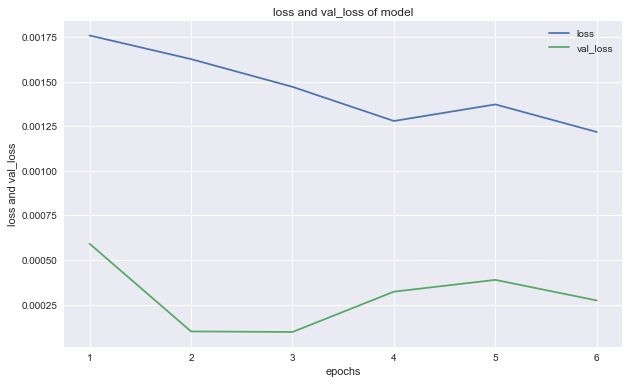

In [568]:
# 控制台打印历史loss及val_loss
print(hist.history['loss'])
print(hist.history['val_loss'])

    # 可视化历史loss及val_loss
plot_loss(hist.history['loss'], hist.history['val_loss'])

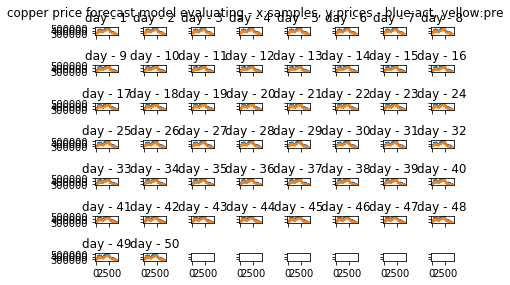

In [514]:
model_visulaization_multi_step(y_test, predicted)

In [518]:
predicted[1]

array([ 421.89117432,  420.3729248 ,  419.5118103 ,  420.51168823,
        417.72668457,  417.84082031,  419.85653687,  419.02511597,
        417.91744995,  418.38174438,  417.94400024,  418.20083618,
        417.85778809,  418.65219116,  418.35159302,  417.32119751,
        420.57498169,  417.59262085,  417.64477539,  420.5585022 ,
        416.95089722,  417.75582886,  418.73141479,  420.38336182,
        416.95397949,  418.52368164,  416.60375977,  417.69830322,
        415.49972534,  418.20544434,  418.33969116,  417.42077637,
        418.83618164,  417.06231689,  417.26052856,  418.14483643,
        416.86694336,  418.03115845,  417.42095947,  417.21591187,
        414.68505859,  418.76516724,  419.60354614,  419.10299683,
        420.3994751 ,  417.35098267,  416.88433838,  419.87332153,
        419.59713745,  414.92880249], dtype=float32)

In [522]:
y_test[1]

array([ 443. ,  443.5,  441.5,  439. ,  438. ,  438. ,  437.5,  437.5,
        438. ,  439. ,  437. ,  436.5,  433.5,  434. ,  435. ,  435. ,
        435.5,  435.5,  435. ,  433.5,  435. ,  437.5,  437.5,  440. ,
        438.5,  437.5,  438. ,  443. ,  445. ,  445. ,  445. ,  442.5,
        443. ,  444.5,  447.5,  447. ,  447. ,  450. ,  444. ,  443. ,
        443. ,  444.5,  442.5,  438.5,  438.5,  439.5,  438.5,  437.5,
        436. ,  437.5])